# 1. Food101 classification

- Recognizing pictured food dishes using deep learning
- We will use transfer learning for this food images classification

`Transfer Learning` is a machine learning technique where you use a pre-trained neural network to solve a problem that is similar to the problem the network was originally trained to solve.

We can use pre-trained models for general image classification. Convolutional layers let us turn an image into a vector. Dense layers use the vector to make the predictions. Instead of training a model from scratch, we can use transfer learning and re-use already trained convolutional layers. First, we will train a small model (150x150) before training a big one (299x299). We will experiment with Learning rate and save the best model using callbacks and checkpointing.
To avoid overfitting, we will use dropout and augmentation.

**Notes**: 
1. We will be using just a subset(sample) of this large dataset for this demonstration to minimize training time and resourses required
2. A system with GPU will be needed for experimentation and training the models

## 1.1 Obtaining and exploring image data
**Dataset**: https://s3.amazonaws.com/fast-ai-imageclas/food-101.tgz

In [1]:
!pip install split-folders --quiet
!pip install seaborn --quiet

In [2]:
# Import required libraries
import os
import splitfolders
import tarfile
import shutil
from shutil import copy
from shutil import copytree, rmtree
import collections
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2022-12-17 04:31:20.018280: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
print('tf_version:', tf.__version__)
print('device_type:', tf.config.list_physical_devices('GPU'))

tf_version: 2.9.1
device_type: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-12-17 04:31:22.506016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 04:31:22.528936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 04:31:22.529544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
# set seed
tf.random.set_seed(1)

### 1.1.1 Data download

In [5]:
# download dataset
!mkdir ./data

!wget --no-check-certificate \
    https://s3.amazonaws.com/fast-ai-imageclas/food-101.tgz \
    -O ./data/food-101.tgz

--2022-12-17 04:31:23--  https://s3.amazonaws.com/fast-ai-imageclas/food-101.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.129.136, 54.231.204.88, 52.217.229.176, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.129.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5686607260 (5.3G) [application/x-tar]
Saving to: ‘./data/food-101.tgz’

./data/food-101.tgz 100%[===================>]   5.30G  42.9MB/s    in 1m 56s  

2022-12-17 04:33:19 (46.9 MB/s) - ‘./data/food-101.tgz’ saved [5686607260/5686607260]



In [6]:
# Extract from archive
with tarfile.open('./data/food-101.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [7]:
# Check the extracted dataset folder
!ls ./data/food-101/

classes.txt  h5  images  labels.txt  test.json	test.txt  train.json  train.txt


### 1.1.2 EDA

In [8]:
!head ./data/food-101/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [9]:
!head ./data/food-101/test.txt

apple_pie/1011328
apple_pie/101251
apple_pie/1034399
apple_pie/103801
apple_pie/1038694
apple_pie/1047447
apple_pie/1068632
apple_pie/110043
apple_pie/1106961
apple_pie/1113017


In [10]:
!head ./data/food-101/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


In [11]:
data_dir_org = './data/food-101/images'

print(os.listdir(data_dir_org))
print('number of food image classes:', len(os.listdir(data_dir_org)))

['takoyaki', 'ice_cream', 'dumplings', 'strawberry_shortcake', 'bibimbap', 'red_velvet_cake', 'clam_chowder', 'chicken_quesadilla', 'escargots', 'huevos_rancheros', 'chicken_wings', 'eggs_benedict', 'pulled_pork_sandwich', 'spaghetti_carbonara', 'gnocchi', 'donuts', 'baklava', 'caprese_salad', 'peking_duck', 'deviled_eggs', 'cheesecake', 'paella', 'miso_soup', 'beet_salad', 'edamame', 'samosa', 'beignets', 'shrimp_and_grits', 'carrot_cake', 'caesar_salad', 'greek_salad', 'gyoza', 'pork_chop', 'grilled_cheese_sandwich', 'chocolate_mousse', 'frozen_yogurt', 'prime_rib', 'filet_mignon', 'tuna_tartare', 'baby_back_ribs', 'poutine', 'hummus', 'falafel', 'fried_calamari', 'breakfast_burrito', 'lasagna', 'sashimi', 'lobster_roll_sandwich', 'cannoli', 'pancakes', 'cheese_plate', 'pizza', 'club_sandwich', 'ceviche', 'omelette', 'beef_tartare', 'fried_rice', 'fish_and_chips', 'hot_and_sour_soup', 'french_fries', 'tacos', 'guacamole', 'french_onion_soup', 'croque_madame', 'bread_pudding', 'grille

In [12]:
# number of images in each class
for cls in os.listdir(data_dir_org):
    print(cls, ':', len(os.listdir(data_dir_org + '/' + cls)))

takoyaki : 1000
ice_cream : 1000
dumplings : 1000
strawberry_shortcake : 1000
bibimbap : 1000
red_velvet_cake : 1000
clam_chowder : 1000
chicken_quesadilla : 1000
escargots : 1000
huevos_rancheros : 1000
chicken_wings : 1000
eggs_benedict : 1000
pulled_pork_sandwich : 1000
spaghetti_carbonara : 1000
gnocchi : 1000
donuts : 1000
baklava : 1000
caprese_salad : 1000
peking_duck : 1000
deviled_eggs : 1000
cheesecake : 1000
paella : 1000
miso_soup : 1000
beet_salad : 1000
edamame : 1000
samosa : 1000
beignets : 1000
shrimp_and_grits : 1000
carrot_cake : 1000
caesar_salad : 1000
greek_salad : 1000
gyoza : 1000
pork_chop : 1000
grilled_cheese_sandwich : 1000
chocolate_mousse : 1000
frozen_yogurt : 1000
prime_rib : 1000
filet_mignon : 1000
tuna_tartare : 1000
baby_back_ribs : 1000
poutine : 1000
hummus : 1000
falafel : 1000
fried_calamari : 1000
breakfast_burrito : 1000
lasagna : 1000
sashimi : 1000
lobster_roll_sandwich : 1000
cannoli : 1000
pancakes : 1000
cheese_plate : 1000
pizza : 1000
cl

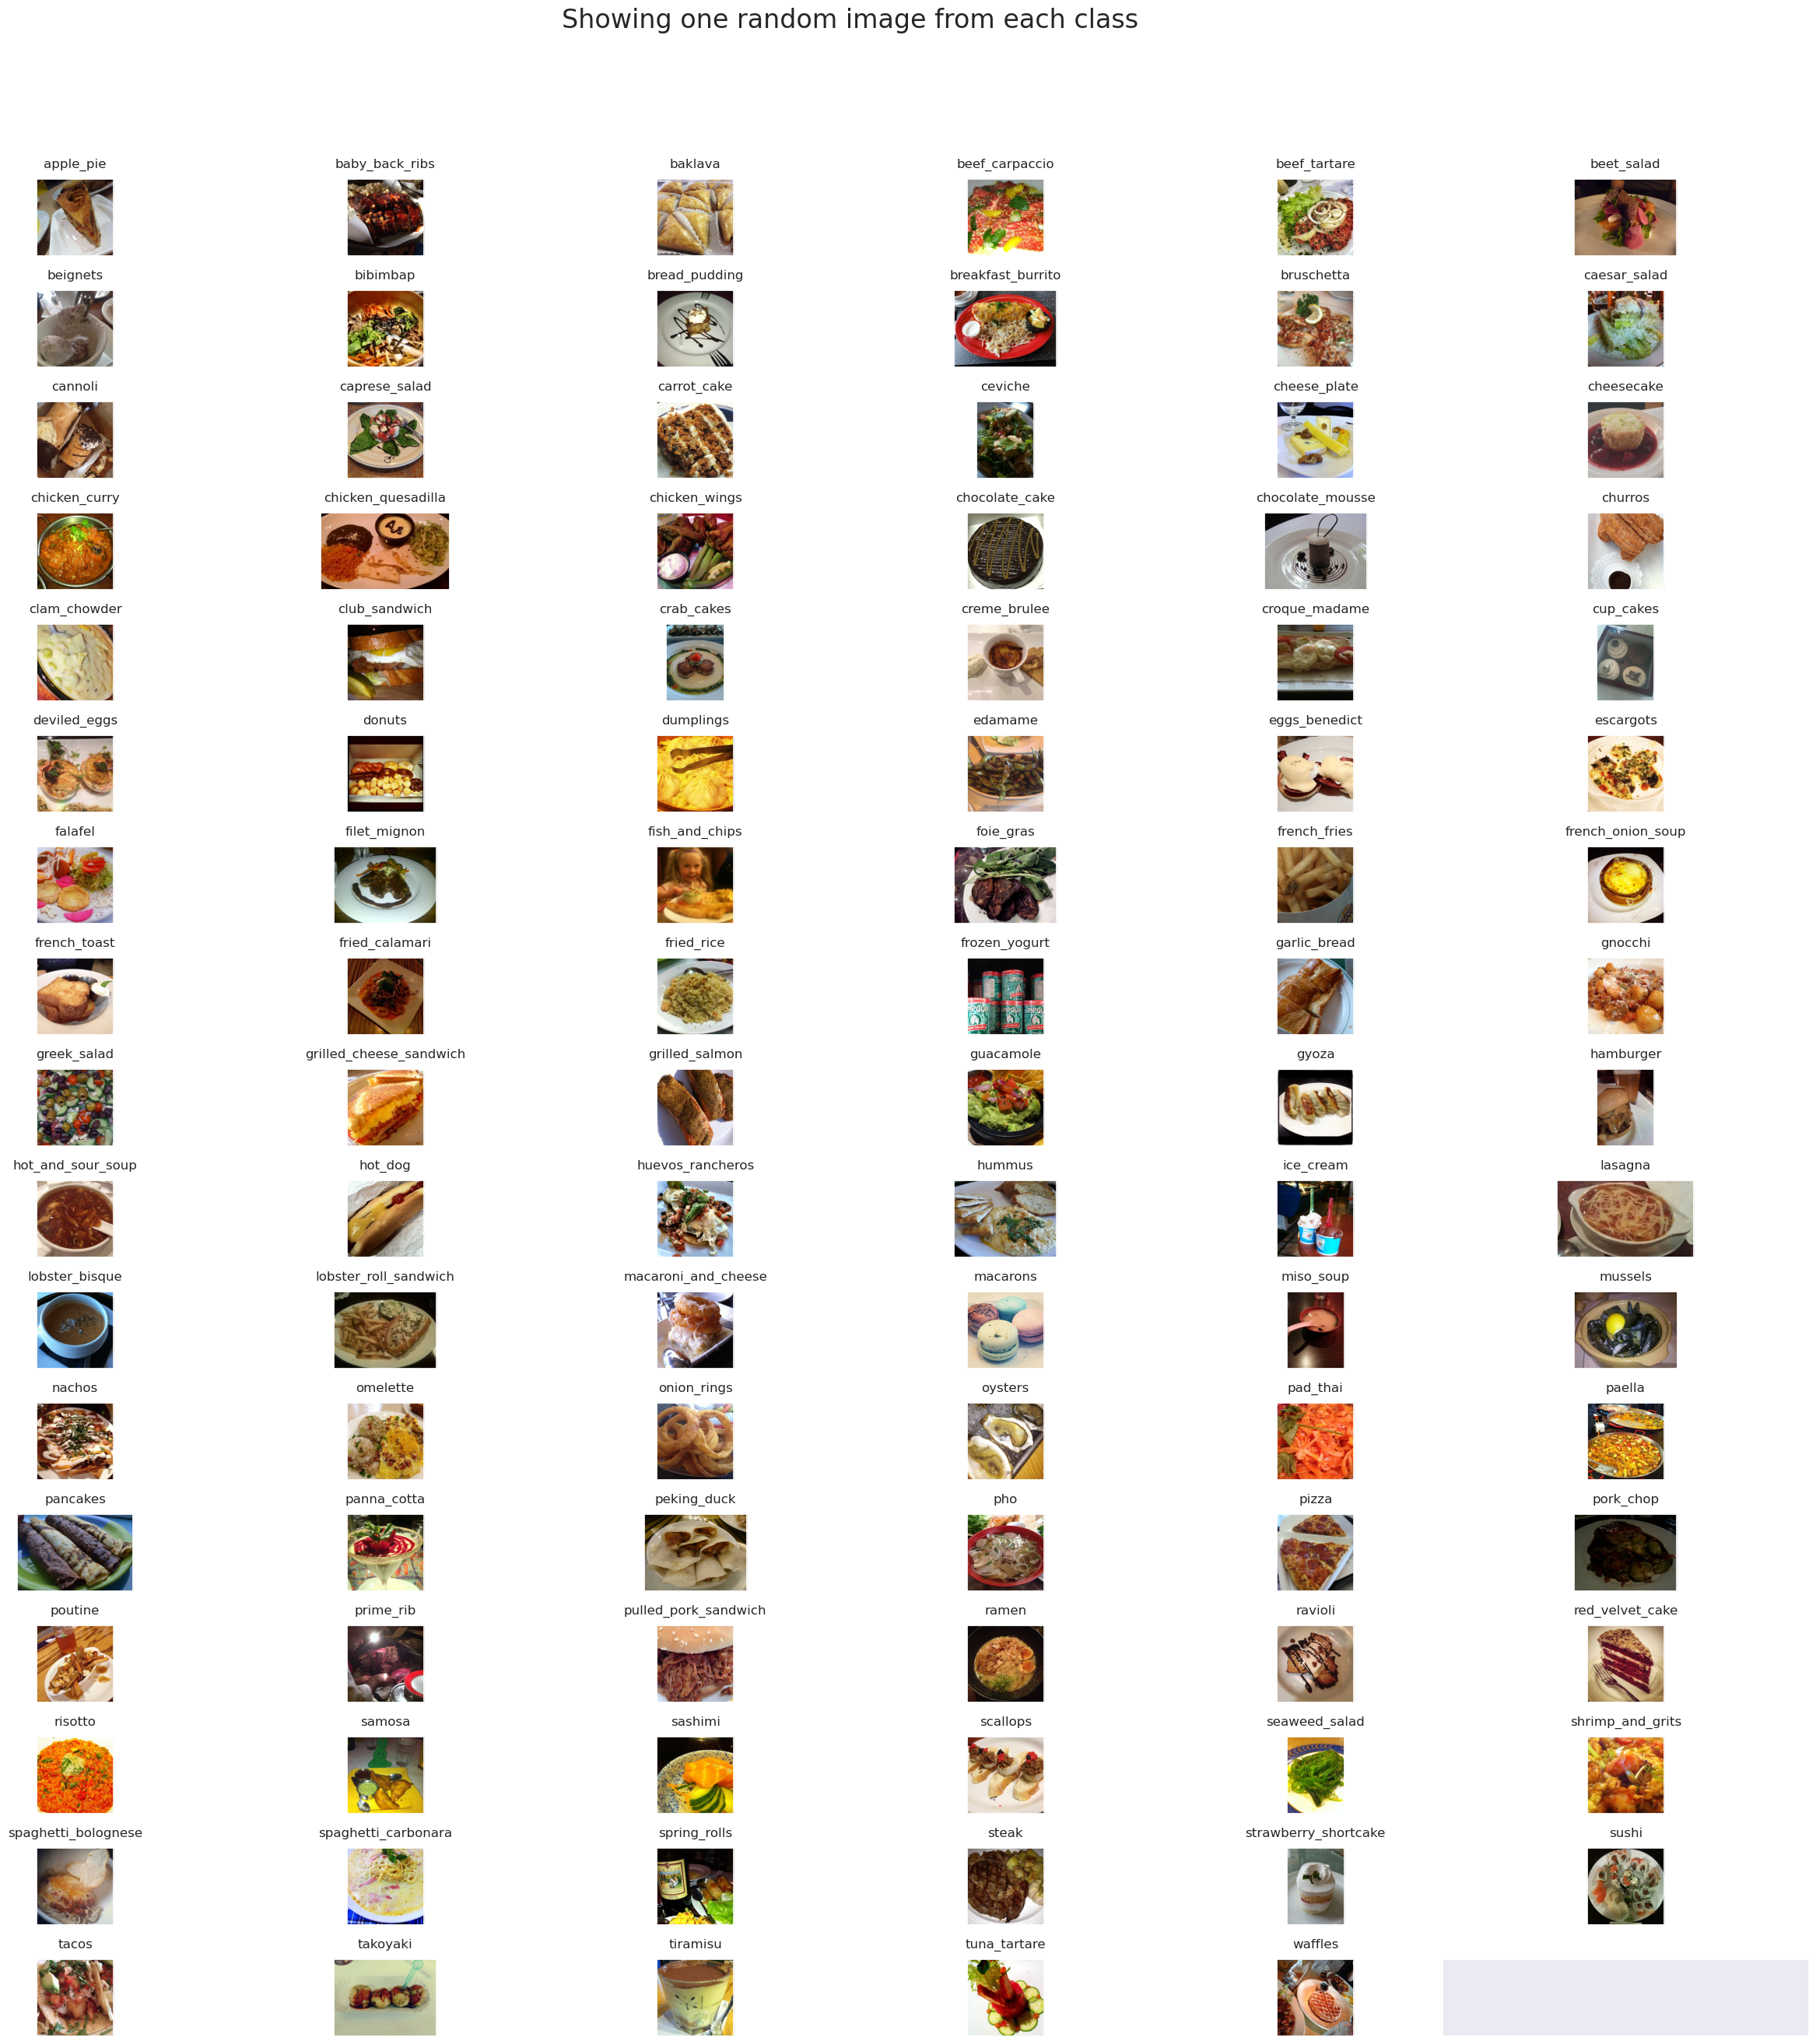

In [13]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir_org = './data/food-101/images'
foods_sorted = sorted(os.listdir(data_dir_org))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir_org,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir_org,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

### 1.1.3 Split the image dataset
- Split images data into `train` and `val` using `train.txt` and `test.txt`

In [14]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [15]:
# Create required folders
!mkdir ./data/food-101/dataset
!mkdir ./data/food-101/dataset_mini

In [16]:
# Prepare 'train' dataset by copying images from food-101/images to food-101/train using the file train.txt
# %cd /
print("Creating train data...")
prepare_data('./data/food-101/train.txt', './data/food-101/images', './data/food-101/dataset/train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [17]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find ./data/food-101/dataset/train/ -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [18]:
# Prepare 'val' dataset by copying images from food-101/images to food-101/dataset/test using the file test.txt
# %cd /
print("Creating val data...")
prepare_data('./data/food-101/test.txt', './data/food-101/images', './data/food-101/dataset/test')

Creating val data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying imag

In [19]:
# Check how many files are in the 'test' folder
print("Total number of samples in test folder")
!find ./data/food-101/dataset/test/ -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


### 1.1.4 Create a subset of data with few classes
- We now have train and test data ready
- But to experiment and try different architectures, working on the whole data with 101 classes takes a lot of time and computation
- To proceed with further experiments, let's create a subset of the dataset in dataset_mini folder limiting the dataset to 3+ classes
- Since the original problem is multiclass classification which makes key aspects of architectural decisions different from that of binary classification, choosing 3+ classes is a good start instead of 2

In [20]:
# List of all 101 types of foods(sorted alphabetically)
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [21]:
# Helper method to create a subset of the dataset in dataset_mini folder limiting the dataset to 3+ classes
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [22]:
# picking 8 food items and generating separate data folders for the same
food_list = ['cup_cakes', 'french_fries', 'hamburger', 'pizza', 'ramen', 'onion_rings', 'samosa', 'waffles']
src_train = 'data/food-101/dataset/train'
dest_train = 'data/food-101/dataset/train_interim'
src_test = 'data/food-101/dataset/test'
dest_test = 'data/food-101/dataset_mini/test'

In [23]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into cup_cakes
Copying images into french_fries
Copying images into hamburger
Copying images into pizza
Copying images into ramen
Copying images into onion_rings
Copying images into samosa
Copying images into waffles


In [24]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into cup_cakes
Copying images into french_fries
Copying images into hamburger
Copying images into pizza
Copying images into ramen
Copying images into onion_rings
Copying images into samosa
Copying images into waffles


In [25]:
print("Total number of samples in train_interim folder:")

!find data/food-101/dataset/train_interim -type d -or -type f -printf '.' | wc -c

Total number of samples in train_interim folder:
6000


In [26]:
print("Total number of samples in dataset_mini/test folder:")
!find data/food-101/dataset_mini/test -type d -or -type f -printf '.' | wc -c

Total number of samples in dataset_mini/test folder:
2000


In [27]:
# split train_interim folder into train and val
input_folder = "./data/food-101/dataset/train_interim"
output = "./data/food-101/dataset_mini/"
splitfolders.ratio(input_folder, output=output, 
                   seed=42, ratio=(.8, .2), 
                   group_prefix=None)

In [28]:
print("Total number of samples in dataset_mini/train folder:")

!find data/food-101/dataset_mini/train -type d -or -type f -printf '.' | wc -c

Total number of samples in dataset_mini/train folder:
4800


In [29]:
print("Total number of samples in dataset_mini/val folder:")

!find data/food-101/dataset_mini/val -type d -or -type f -printf '.' | wc -c

Total number of samples in dataset_mini/val folder:
1200


In [30]:
# Cleanup
if os.path.exists('./data/food-101/images'):
    shutil.rmtree('./data/food-101/images')

!rm ./data/food-101.tgz

In [31]:
data_dir = './data/food-101/dataset_mini/'
train_dir = data_dir + 'train'
val_dir = data_dir + 'val'
test_dir = data_dir + 'test'

In [32]:
# number of images in each class

print("\n", "train_data_dir:")

for cls in os.listdir(train_dir):
    print(cls, ':', len(os.listdir(train_dir + '/' + cls)))

print("\n", "val_data_dir:")

for cls in os.listdir(val_dir):
    print(cls, ':', len(os.listdir(val_dir + '/' + cls)))

print("\n", "test_data_dir:") 

for cls in os.listdir(test_dir):
    print(cls, ':', len(os.listdir(test_dir + '/' + cls))) 


 train_data_dir:
samosa : 600
pizza : 600
french_fries : 600
ramen : 600
hamburger : 600
waffles : 600
cup_cakes : 600
onion_rings : 600

 val_data_dir:
samosa : 150
pizza : 150
french_fries : 150
ramen : 150
hamburger : 150
waffles : 150
cup_cakes : 150
onion_rings : 150

 test_data_dir:
samosa : 250
pizza : 250
french_fries : 250
ramen : 250
hamburger : 250
waffles : 250
cup_cakes : 250
onion_rings : 250


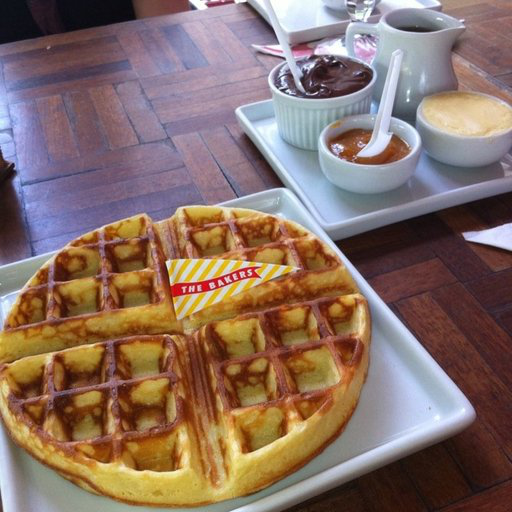

In [33]:
# check one image
path = train_dir + '/waffles'
name = '1005295.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

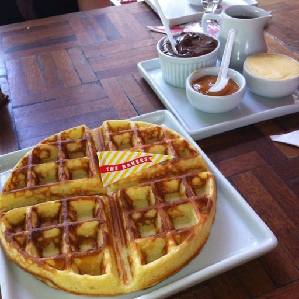

In [34]:
img = load_img(fullname, target_size=(299, 299))
img

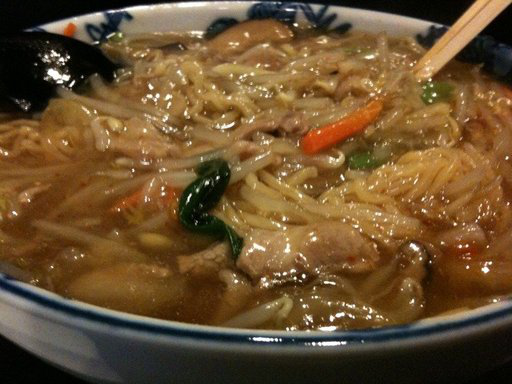

In [35]:
# check another image
path = train_dir + '/ramen'
name = '10602.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

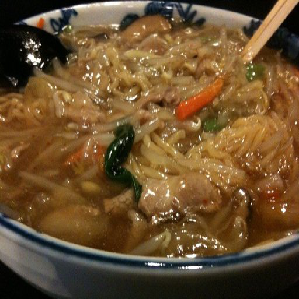

In [36]:
img = load_img(fullname, target_size=(299, 299))
img

In [37]:
x = np.array(img)
x.shape

(299, 299, 3)

## 1.2 Build model and train

We will be using pre-trained convolutional neural network model known as `Xception`.

Pre-trained convolutional neural networks:
- Imagenet dataset: https://www.image-net.org/
- Pre-trained models: https://keras.io/api/applications/

### 1.2.1 Preprocessing

In [38]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    shuffle=True
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 4800 images belonging to 8 classes.
Found 1200 images belonging to 8 classes.


In [39]:
train_generator.class_indices

{'cup_cakes': 0,
 'french_fries': 1,
 'hamburger': 2,
 'onion_rings': 3,
 'pizza': 4,
 'ramen': 5,
 'samosa': 6,
 'waffles': 7}

In [40]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)
base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(8)(vectors)

model = keras.Model(inputs, outputs)

2022-12-17 04:35:09.999608: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-17 04:35:10.000529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 04:35:10.001331: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 04:35:10.002192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

In [41]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [42]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 8)                 16392     
                                                                 
Total params: 20,877,872
Trainable params: 16,392
Non-trainable params: 20,861,480
_________________________________________________________________


In [43]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5


2022-12-17 04:35:15.474266: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-17 04:35:16.769703: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-17 04:35:16.770598: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-17 04:35:16.770640: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-17 04:35:16.771576: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-17 04:35:16.771668: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


150/150 [==============================] - 29s 155ms/step - loss: 0.9871 - accuracy: 0.7752 - val_loss: 0.9677 - val_accuracy: 0.7900
Epoch 2/5
150/150 [==============================] - 22s 146ms/step - loss: 0.5475 - accuracy: 0.8623 - val_loss: 0.8154 - val_accuracy: 0.8383
Epoch 3/5
150/150 [==============================] - 22s 146ms/step - loss: 0.3814 - accuracy: 0.8954 - val_loss: 0.9155 - val_accuracy: 0.8192
Epoch 4/5
150/150 [==============================] - 22s 147ms/step - loss: 0.3619 - accuracy: 0.9067 - val_loss: 1.1911 - val_accuracy: 0.8017
Epoch 5/5
150/150 [==============================] - 22s 146ms/step - loss: 0.2410 - accuracy: 0.9344 - val_loss: 0.9631 - val_accuracy: 0.8367


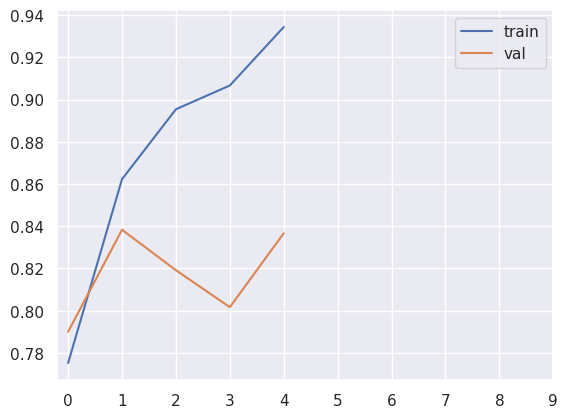

In [44]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

### 1.2.2 Adjusting the learning rate

- Trying different values

In [45]:
def make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(8)(vectors)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [46]:
scores = {}

for lr in [0.0001, 0.001, 0.005, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_generator, epochs=10, validation_data=val_generator)
    scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/10
150/150 [==============================] - 25s 152ms/step - loss: 1.5263 - accuracy: 0.4908 - val_loss: 1.0194 - val_accuracy: 0.7250
Epoch 2/10
150/150 [==============================] - 22s 146ms/step - loss: 0.8533 - accuracy: 0.7625 - val_loss: 0.7330 - val_accuracy: 0.7908
Epoch 3/10
150/150 [==============================] - 22s 147ms/step - loss: 0.6724 - accuracy: 0.8090 - val_loss: 0.6227 - val_accuracy: 0.8192
Epoch 4/10
150/150 [==============================] - 22s 147ms/step - loss: 0.5885 - accuracy: 0.8250 - val_loss: 0.5665 - val_accuracy: 0.8250
Epoch 5/10
150/150 [==============================] - 22s 146ms/step - loss: 0.5389 - accuracy: 0.8381 - val_loss: 0.5305 - val_accuracy: 0.8358
Epoch 6/10
150/150 [==============================] - 22s 145ms/step - loss: 0.5029 - accuracy: 0.8454 - val_loss: 0.5051 - val_accuracy: 0.8433
Epoch 7/10
150/150 [==============================] - 22s 146ms/step - loss: 0.4765 - accuracy: 0.8535 - val_loss: 0.4878 -

In [47]:
del scores[0.1]
del scores[0.01]

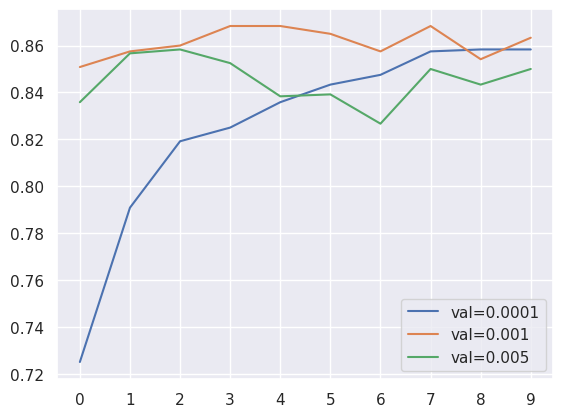

In [48]:
for lr, hist in scores.items():
    # plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [49]:
learning_rate = 0.005

### 1.2.3 Checkpointing
- Saving the best model only
- Training a model with callbacks

In [50]:
model.save_weights('model_v1.h5', save_format='h5')

In [51]:
chechpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [52]:
learning_rate = 0.005

model = make_model(learning_rate=learning_rate)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[chechpoint]
)

Epoch 1/10
150/150 [==============================] - 25s 152ms/step - loss: 0.7007 - accuracy: 0.7881 - val_loss: 0.5525 - val_accuracy: 0.8292
Epoch 2/10
150/150 [==============================] - 22s 148ms/step - loss: 0.4232 - accuracy: 0.8677 - val_loss: 0.5799 - val_accuracy: 0.8375
Epoch 3/10
150/150 [==============================] - 23s 150ms/step - loss: 0.2769 - accuracy: 0.9023 - val_loss: 0.5953 - val_accuracy: 0.8425
Epoch 4/10
150/150 [==============================] - 22s 146ms/step - loss: 0.2025 - accuracy: 0.9302 - val_loss: 0.6411 - val_accuracy: 0.8342
Epoch 5/10
150/150 [==============================] - 22s 146ms/step - loss: 0.1371 - accuracy: 0.9588 - val_loss: 0.6267 - val_accuracy: 0.8358
Epoch 6/10
150/150 [==============================] - 22s 148ms/step - loss: 0.1028 - accuracy: 0.9685 - val_loss: 0.6079 - val_accuracy: 0.8508
Epoch 7/10
150/150 [==============================] - 22s 145ms/step - loss: 0.0781 - accuracy: 0.9790 - val_loss: 0.6562 - val_ac

### 1.2.4 Adding more layers
- Adding one inner dense layer
- Experimenting with different sizes of inner layer

In [53]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    
    outputs = keras.layers.Dense(8)(inner)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [54]:
learning_rate = 0.005

scores = {}

for size in [16, 128, 512, 1024]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_generator, epochs=10, validation_data=val_generator)
    scores[size] = history.history

    print()
    print()

16
Epoch 1/10
150/150 [==============================] - 25s 150ms/step - loss: 0.7302 - accuracy: 0.7669 - val_loss: 0.5498 - val_accuracy: 0.8283
Epoch 2/10
150/150 [==============================] - 22s 145ms/step - loss: 0.4159 - accuracy: 0.8658 - val_loss: 0.4785 - val_accuracy: 0.8500
Epoch 3/10
150/150 [==============================] - 22s 145ms/step - loss: 0.3336 - accuracy: 0.8888 - val_loss: 0.5086 - val_accuracy: 0.8508
Epoch 4/10
150/150 [==============================] - 23s 150ms/step - loss: 0.2559 - accuracy: 0.9177 - val_loss: 0.5987 - val_accuracy: 0.8275
Epoch 5/10
150/150 [==============================] - 22s 144ms/step - loss: 0.1907 - accuracy: 0.9398 - val_loss: 0.5792 - val_accuracy: 0.8333
Epoch 6/10
150/150 [==============================] - 22s 145ms/step - loss: 0.1468 - accuracy: 0.9517 - val_loss: 0.6174 - val_accuracy: 0.8483
Epoch 7/10
150/150 [==============================] - 22s 146ms/step - loss: 0.1024 - accuracy: 0.9704 - val_loss: 0.6813 - val

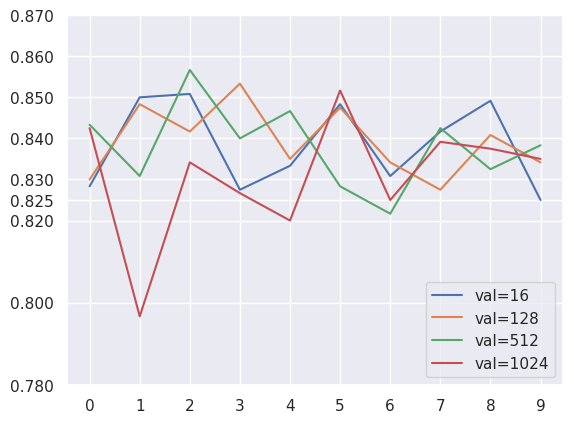

In [55]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
plt.yticks([0.78, 0.80, 0.82, 0.825, 0.83, 0.84, 0.85, 0.86, 0.87])
plt.legend()

In [56]:
size_inner = 128

### 1.2.5 Regularization and dropout
- Regularizing by freezing a part of the network
- Adding dropout to our model
- Experimenting with different values

In [57]:
def make_model(learning_rate=0.001, size_inner=512, droprate=0.2):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(8)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [58]:
learning_rate = 0.005
size = 128

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_generator, epochs=20, validation_data=val_generator)
    scores[droprate] = history.history

    print()
    print()

0.0
Epoch 1/20
150/150 [==============================] - 25s 151ms/step - loss: 0.7010 - accuracy: 0.7854 - val_loss: 0.5302 - val_accuracy: 0.8367
Epoch 2/20
150/150 [==============================] - 22s 147ms/step - loss: 0.4058 - accuracy: 0.8685 - val_loss: 0.5471 - val_accuracy: 0.8308
Epoch 3/20
150/150 [==============================] - 22s 144ms/step - loss: 0.2964 - accuracy: 0.9008 - val_loss: 0.5441 - val_accuracy: 0.8400
Epoch 4/20
150/150 [==============================] - 22s 145ms/step - loss: 0.2099 - accuracy: 0.9306 - val_loss: 0.6423 - val_accuracy: 0.8358
Epoch 5/20
150/150 [==============================] - 22s 144ms/step - loss: 0.1551 - accuracy: 0.9460 - val_loss: 0.6850 - val_accuracy: 0.8283
Epoch 6/20
150/150 [==============================] - 22s 145ms/step - loss: 0.1480 - accuracy: 0.9477 - val_loss: 0.6958 - val_accuracy: 0.8383
Epoch 7/20
150/150 [==============================] - 22s 144ms/step - loss: 0.1002 - accuracy: 0.9654 - val_loss: 0.7415 - va

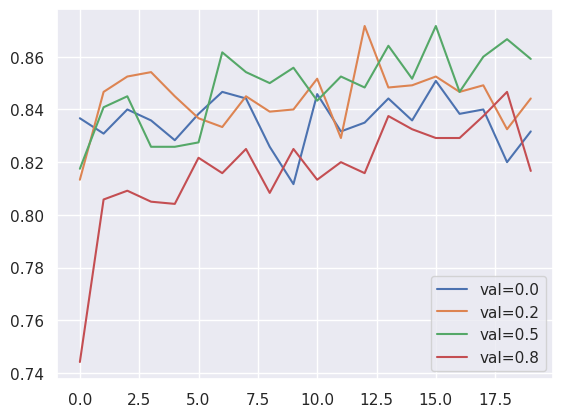

In [59]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

# plt.ylim(0.78, 0.86)
plt.legend()

In [60]:
droprate=0.2

### 1.2.6 Data augmentation
- Different data augmentations
- Training a model with augmentations
- How to select data augmentations?

In [61]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=10,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   # fill_mode='nearest'
                                  )

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    shuffle=True,
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                )

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 4800 images belonging to 8 classes.
Found 1200 images belonging to 8 classes.


In [62]:
learning_rate = 0.005
size = 128
droprate = 0.2

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_generator, epochs=20, validation_data=val_generator)

Epoch 1/20
150/150 [==============================] - 43s 276ms/step - loss: 0.9619 - accuracy: 0.6927 - val_loss: 0.5796 - val_accuracy: 0.8200
Epoch 2/20
150/150 [==============================] - 41s 272ms/step - loss: 0.7174 - accuracy: 0.7623 - val_loss: 0.5526 - val_accuracy: 0.8283
Epoch 3/20
150/150 [==============================] - 41s 272ms/step - loss: 0.6891 - accuracy: 0.7679 - val_loss: 0.5444 - val_accuracy: 0.8333
Epoch 4/20
150/150 [==============================] - 41s 272ms/step - loss: 0.6616 - accuracy: 0.7767 - val_loss: 0.5139 - val_accuracy: 0.8525
Epoch 5/20
150/150 [==============================] - 41s 272ms/step - loss: 0.6395 - accuracy: 0.7933 - val_loss: 0.5167 - val_accuracy: 0.8558
Epoch 6/20
150/150 [==============================] - 41s 270ms/step - loss: 0.6142 - accuracy: 0.8002 - val_loss: 0.5082 - val_accuracy: 0.8417
Epoch 7/20
150/150 [==============================] - 41s 270ms/step - loss: 0.6037 - accuracy: 0.8027 - val_loss: 0.4774 - val_ac

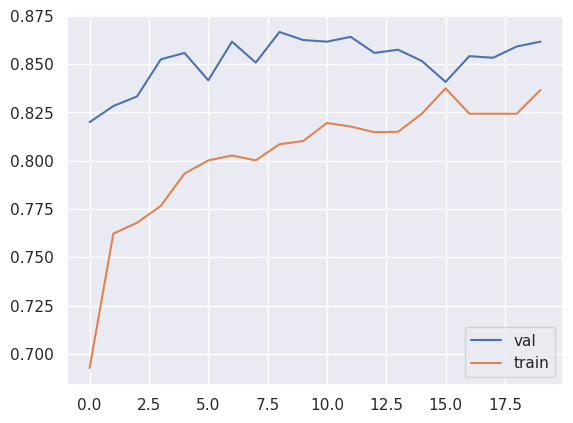

In [63]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

## 1.3 Training a larger model
- Train a 299x299 model

In [64]:
def make_model(input_size=299, learning_rate=0.001, size_inner=512,
               droprate=0.2):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(8)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [65]:
input_size = 299

In [66]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

train_ds = train_gen.flow_from_directory(
    train_dir,
    target_size=(input_size, input_size),
    batch_size=32
)


val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = train_gen.flow_from_directory(
    val_dir,
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False
)

Found 4800 images belonging to 8 classes.
Found 1200 images belonging to 8 classes.


In [67]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [68]:
# Defining early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',
    min_delta = 0,
    patience = 2,
    verbose = 0,
    restore_best_weights = True
)

In [69]:
learning_rate = 0.0005
size = 128
droprate = 0.2

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=20, validation_data=val_ds,
                   callbacks=[checkpoint, early_stopping])

Epoch 1/20
150/150 [==============================] - 119s 770ms/step - loss: 0.5461 - accuracy: 0.8467 - val_loss: 0.2607 - val_accuracy: 0.9200
Epoch 2/20
150/150 [==============================] - 114s 761ms/step - loss: 0.2631 - accuracy: 0.9187 - val_loss: 0.2398 - val_accuracy: 0.9292
Epoch 3/20
150/150 [==============================] - 114s 760ms/step - loss: 0.2065 - accuracy: 0.9377 - val_loss: 0.2349 - val_accuracy: 0.9233
Epoch 4/20
150/150 [==============================] - 114s 760ms/step - loss: 0.1903 - accuracy: 0.9379 - val_loss: 0.2277 - val_accuracy: 0.9375
Epoch 5/20
150/150 [==============================] - 113s 755ms/step - loss: 0.1771 - accuracy: 0.9454 - val_loss: 0.2182 - val_accuracy: 0.9417
Epoch 6/20
150/150 [==============================] - 115s 764ms/step - loss: 0.1601 - accuracy: 0.9504 - val_loss: 0.2252 - val_accuracy: 0.9308
Epoch 7/20
150/150 [==============================] - 114s 760ms/step - loss: 0.1278 - accuracy: 0.9617 - val_loss: 0.2427 -

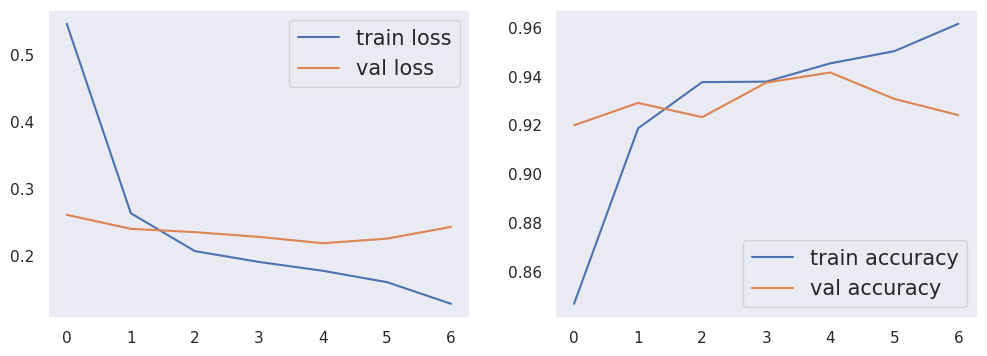

In [70]:
# plot loss and accuracy

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.grid()
plt.legend(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.grid()
plt.legend(fontsize=15)

## 1.4 Using the model
- Loading the model
- Evaluating the model
- Getting predictions

In [71]:
import numpy as np

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications.xception import preprocess_input

In [72]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

Found 2000 images belonging to 8 classes.


In [74]:
model = keras.models.load_model('xception_v4_1_05_0.942.h5')

In [75]:
model.evaluate(test_ds)

63/63 [==============================] - 15s 222ms/step - loss: 0.1353 - accuracy: 0.9630


[0.13527478277683258, 0.9629999995231628]

In [76]:
# path = './data/food-101/dataset_mini/test/onion_rings/1331610.jpg'
# path = './data/food-101/dataset_mini/test/waffles/1195540.jpg'
path = './data/food-101/dataset_mini/test/samosa/144404.jpg'

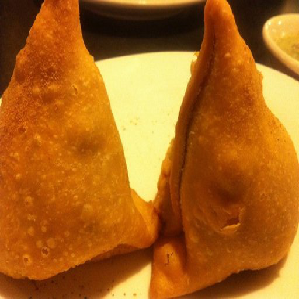

In [77]:
img = load_img(path, target_size=(299, 299))
img

In [78]:
x = np.array(img)
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [79]:
X = preprocess_input(X)

In [80]:
pred = model.predict(X)

1/1 [==============================] - 1s 852ms/step


In [81]:
classes = ['cup_cakes', 'french_fries', 'hamburger', 'pizza', 'ramen', 'onion_rings', 'samosa', 'waffles']

In [82]:
dict(zip(classes, pred[0]))

{'cup_cakes': -1.581987,
 'french_fries': -2.3650863,
 'hamburger': -2.5601494,
 'pizza': 1.1118977,
 'ramen': -3.2538712,
 'onion_rings': -3.1710904,
 'samosa': 8.922007,
 'waffles': -0.11740025}